C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0330
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0112
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0117
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0109
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0117
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0124
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0105
Test Loss: 0.023640526458621025
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
RMSE: 66.85142573354048
MAE: 52.916063925364284
R²: 0.6864741491967541


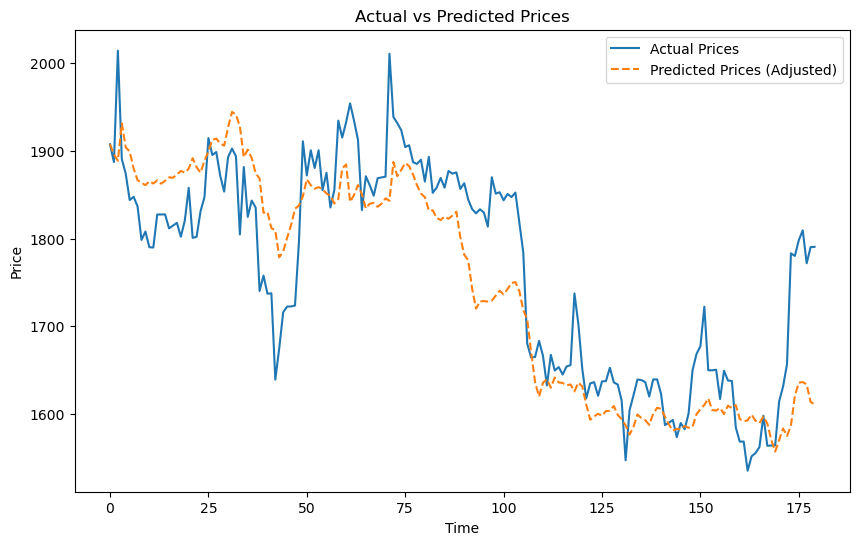

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
file_path = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_full_data_final_cleaned.csv"
data = pd.read_csv(file_path)

# List of original day t columns to be removed
columns_to_remove = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                     'variableBorrowRate', 'stableBorrowRate', 'supplyRate']

# Create lagged features for relevant columns
lag_features = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                'variableBorrowRate', 'stableBorrowRate', 'supplyRate']

# Generate lagged features for the past 1, 2, and 3 days
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)
    data[f'{feature}_lag3'] = data[feature].shift(3)

# Drop rows with NaN values generated due to lagging
data_with_lags = data.dropna()

# Drop the day t columns
data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

# Prepare data for LSTM
# Drop non-numeric columns that are not needed for LSTM model
data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

# Split into features (X) and target (y)
X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
y = data_for_lstm_numeric['inputTokenPriceUSD'].values

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape X for LSTM model (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Predicting the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform y_test and y_pred to original values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Adjust the prediction to start at the same point as the actual values
offset = y_test_original[0] - y_pred[0]
y_pred_adjusted = y_pred + offset

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_adjusted))
mae = mean_absolute_error(y_test_original, y_pred_adjusted)
r2 = r2_score(y_test_original, y_pred_adjusted)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Plot actual vs adjusted predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(y_pred_adjusted, label='Predicted Prices (Adjusted)', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0473
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0147
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0124
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0106
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0116
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0119
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0116
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0095
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0112
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0105
Test Loss: 0.008625315502285957
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
RMSE: 188.89333848792367
MAE: 135.54231981336406
R²: -1.5069330132110785


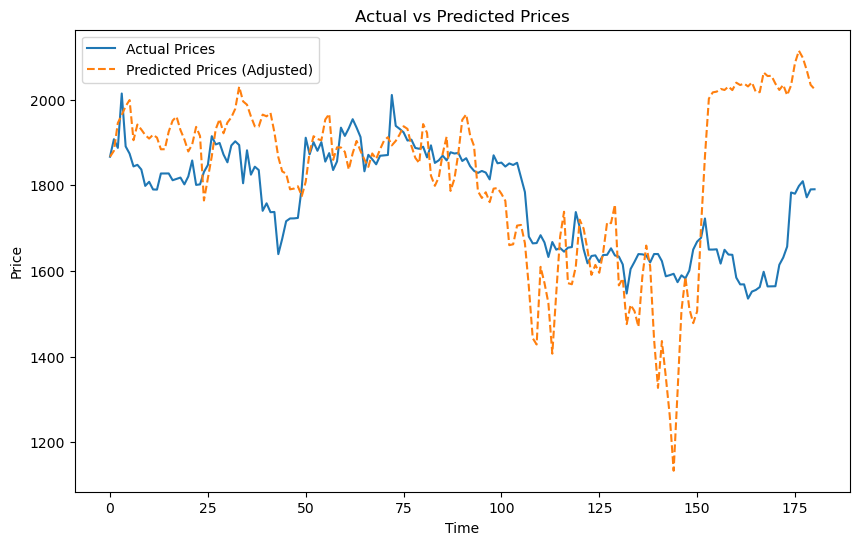

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
file_path = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_data_with_pagerank_final_cleaned.csv"
data = pd.read_csv(file_path)

# List of original day t columns to be removed (including PageRank columns)
columns_to_remove = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                     'variableBorrowRate', 'stableBorrowRate', 'supplyRate',
                     'avg_pagerank', 'total_pagerank']

# Create lagged features for relevant columns (including the two PageRank columns)
lag_features = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                'variableBorrowRate', 'stableBorrowRate', 'supplyRate',
                'avg_pagerank', 'total_pagerank']

# Generate lagged features for the past 1, 2, and 3 days
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)
    data[f'{feature}_lag3'] = data[feature].shift(3)

# Drop rows with NaN values generated due to lagging
data_with_lags = data.dropna()

# Drop the day t columns
data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

# Prepare data for LSTM
# Drop non-numeric columns that are not needed for LSTM model
data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

# Split into features (X) and target (y)
X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
y = data_for_lstm_numeric['inputTokenPriceUSD'].values

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape X for LSTM model (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")

# Predicting the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform y_test and y_pred to original values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Adjust the prediction to start at the same point as the actual values
offset = y_test_original[0] - y_pred[0]
y_pred_adjusted = y_pred + offset

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_adjusted))
mae = mean_absolute_error(y_test_original, y_pred_adjusted)
r2 = r2_score(y_test_original, y_pred_adjusted)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Plot actual vs adjusted predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Prices')
plt.plot(y_pred_adjusted, label='Predicted Prices (Adjusted)', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0350
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0128
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0127
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0112
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0115
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0115
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0098
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0109
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0101
Test Loss: 0.012181099504232407
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0377
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0142
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0136
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0130
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0114
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0102
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0107
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0106
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0114
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0104
Test Loss: 0.010011347942054272
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


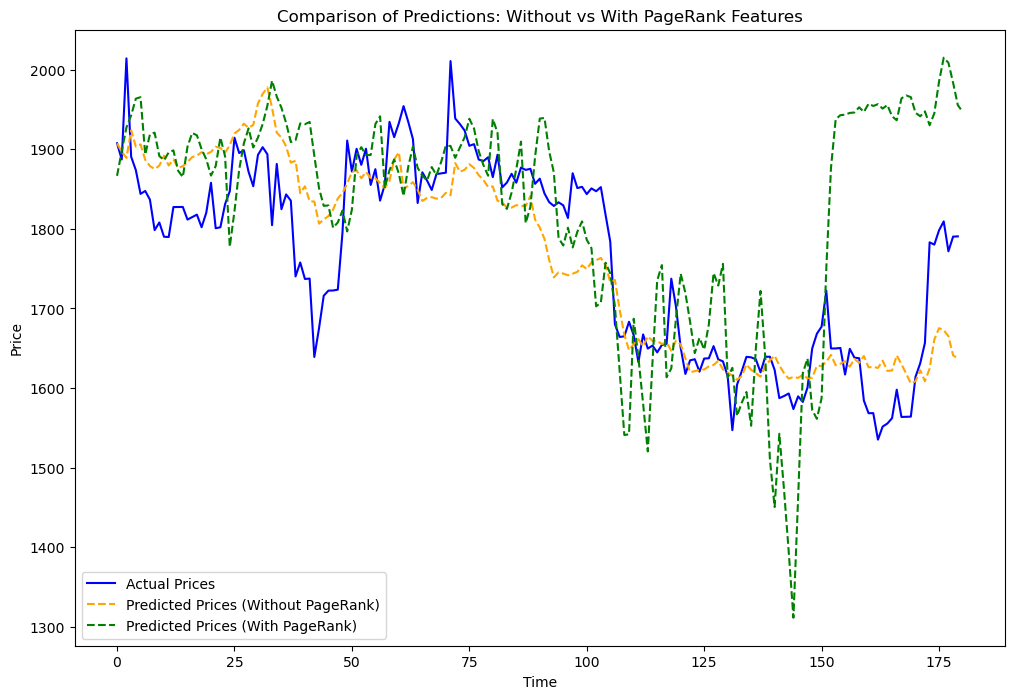

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']

columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(y_test_original_without, label='Actual Prices', color='blue')
plt.plot(y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')
plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0407
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0119
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0120
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0114
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0120
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0106
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0106
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100
Test Loss: 0.013045878149569035
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0406
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0092
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0119
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0102
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0098
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0105
Test Loss: 0.01401851698756218
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


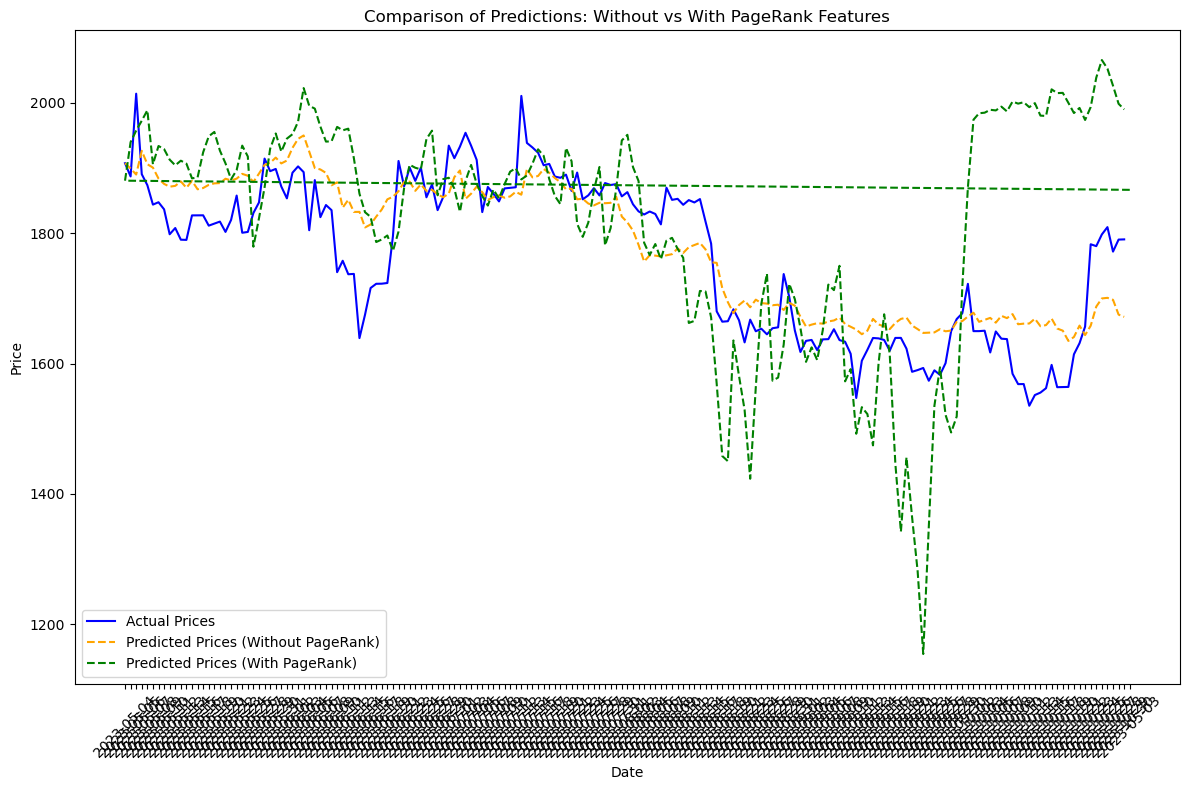

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = data_with_lags['date']

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0356
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0133
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0104
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0111
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0103
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0116
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0094
Test Loss: 0.01238398440182209
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0301
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0145
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0125
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0109
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0116
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0110
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0100
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0097
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0097
Test Loss: 0.006935774348676205
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


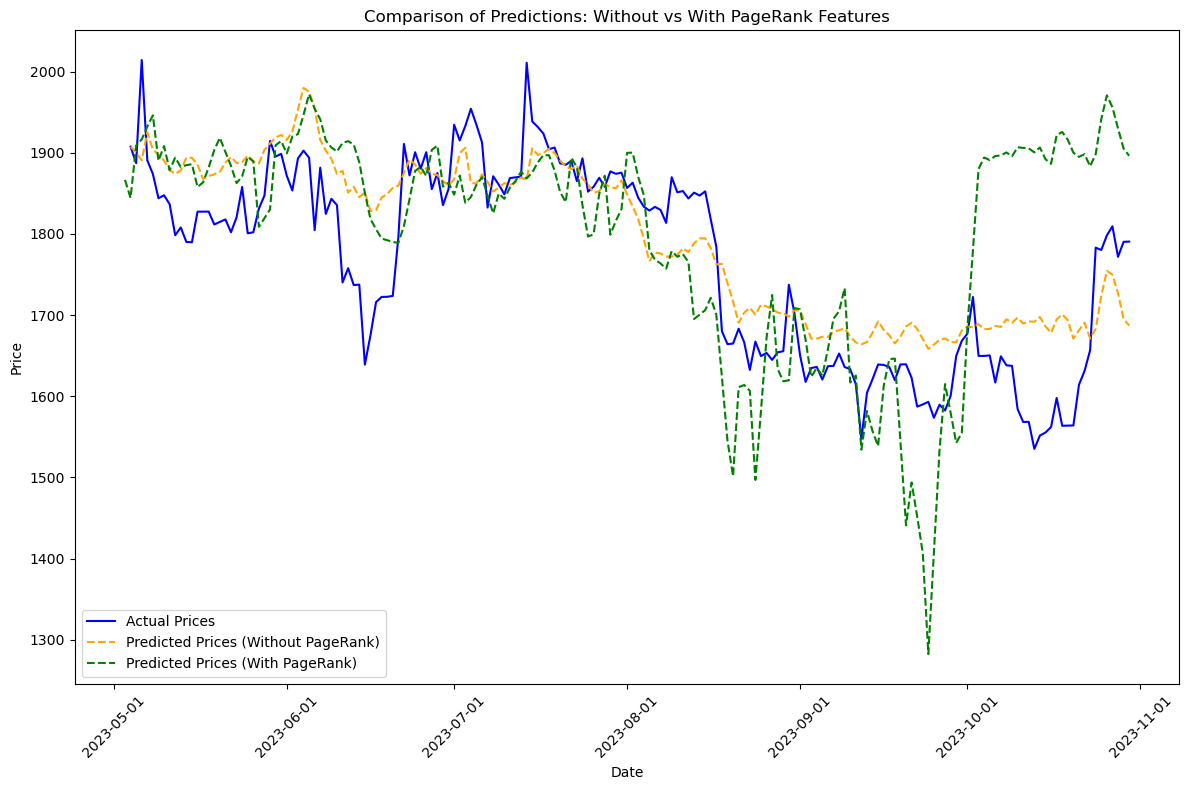

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = pd.to_datetime(data_with_lags['date'])

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    return y_test_original, y_pred_adjusted

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with = build_and_train_model(X_with, y_with)

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label='Predicted Prices (Without PageRank)', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label='Predicted Prices (With PageRank)', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()


Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/716 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0404
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0141
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0123
Epoch 4/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0101
Epoch 5/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0117
Epoch 6/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0114
Epoch 7/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0097
Epoch 8/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0117
Epoch 9/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0092
Epoch 10/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0092
Test Loss: 0.006166852079331875
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Epoch 1/10


C:\Users\tfeder\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0348
Epoch 2/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0141
Epoch 3/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0127
Epoch 4/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0131
Epoch 5/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0102
Epoch 6/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0099
Epoch 7/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0121
Epoch 8/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0104
Epoch 9/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0107
Epoch 10/10
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090
Test Loss: 0.019670560956001282
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
MSE without PageRank features: 4301.570081943365
MSE with PageRank features: 16815.788436340263


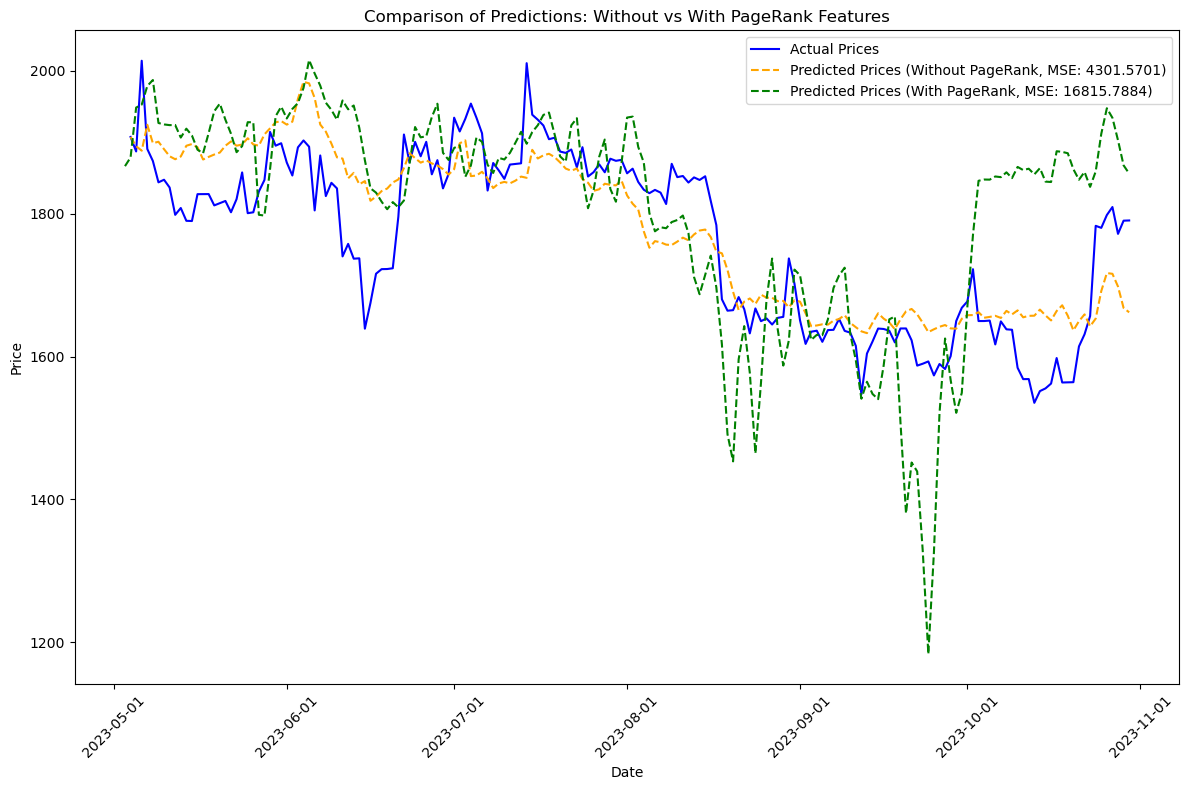

In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from sklearn.metrics import mean_squared_error

def load_and_process_data(file_path, lag_features, columns_to_remove):
    data = pd.read_csv(file_path)
    
    # Generate lagged features for the past 1, 2, and 3 days
    for feature in lag_features:
        data[f'{feature}_lag1'] = data[feature].shift(1)
        data[f'{feature}_lag2'] = data[feature].shift(2)
        data[f'{feature}_lag3'] = data[feature].shift(3)

    # Drop rows with NaN values generated due to lagging
    data_with_lags = data.dropna()

    # Extract the date column before dropping others
    dates = pd.to_datetime(data_with_lags['date'])

    # Drop the day t columns
    data_for_lstm = data_with_lags.drop(columns=columns_to_remove)

    # Drop non-numeric columns that are not needed for LSTM model
    data_for_lstm_numeric = data_for_lstm.drop(columns=['timestamp', 'token', 'id', 'date'])

    # Split into features (X) and target (y)
    X = data_for_lstm_numeric.drop(columns=['inputTokenPriceUSD']).values
    y = data_for_lstm_numeric['inputTokenPriceUSD'].values

    return X, y, dates

def build_and_train_model(X, y):
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scalers only on training data
    split_index = int(0.8 * len(X))
    X_train_raw, X_test_raw = X[:split_index], X[split_index:]
    y_train_raw, y_test_raw = y[:split_index], y[split_index:]

    X_train = scaler_X.fit_transform(X_train_raw)
    X_test = scaler_X.transform(X_test_raw)  # Apply the same scaler fitted on training
    y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))
    y_test = scaler_y.transform(y_test_raw.reshape(-1, 1))

    # Reshape X for LSTM model (samples, timesteps, features)
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train_lstm, y_train, batch_size=1, epochs=10, verbose=1)

    # Evaluate the model on the test data
    loss = model.evaluate(X_test_lstm, y_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Predicting the test set
    y_pred_scaled = model.predict(X_test_lstm)

    # Inverse transform y_test and y_pred to original values
    y_test_original = scaler_y.inverse_transform(y_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Adjust the prediction to start at the same point as the actual values
    offset = y_test_original[0] - y_pred[0]
    y_pred_adjusted = y_pred + offset

    # Calculate MSE
    mse = mean_squared_error(y_test_original, y_pred_adjusted)

    return y_test_original, y_pred_adjusted, mse

# File paths for data
file_path_without_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_full_data_final_cleaned.csv"
file_path_with_pagerank = r"C:\Users\tfeder\Documents\M2 CLASSES\Master Thesis\AAVE_Data\Questions\Tokens_no_lags\WETH_data_with_pagerank_final_cleaned.csv"

# Define columns to lag and remove
columns_to_remove_without = ['balanceUSD', 'totalValueLockedUSD', 'totalBorrowBalanceUSD', 
                             'variableBorrowRate', 'stableBorrowRate', 'supplyRate']
columns_to_remove_with = columns_to_remove_without + ['avg_pagerank', 'total_pagerank']

lag_features_without = columns_to_remove_without
lag_features_with = lag_features_without + ['avg_pagerank', 'total_pagerank']

# Process and train the model without PageRank features
X_without, y_without, dates_without = load_and_process_data(file_path_without_pagerank, lag_features_without, columns_to_remove_without)
y_test_original_without, y_pred_adjusted_without, mse_without = build_and_train_model(X_without, y_without)

# Process and train the model with PageRank features
X_with, y_with, dates_with = load_and_process_data(file_path_with_pagerank, lag_features_with, columns_to_remove_with)
y_test_original_with, y_pred_adjusted_with, mse_with = build_and_train_model(X_with, y_with)

# Print MSE results
print(f"MSE without PageRank features: {mse_without}")
print(f"MSE with PageRank features: {mse_with}")

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Actual Prices', color='blue')
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label=f'Predicted Prices (Without PageRank, MSE: {mse_without:.4f})', linestyle='--', color='orange')
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label=f'Predicted Prices (With PageRank, MSE: {mse_with:.4f})', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.tight_layout()
plt.show()


<bound method Axis.set_major_locator of <matplotlib.axis.XAxis object at 0x00000212C1AB4D10>>

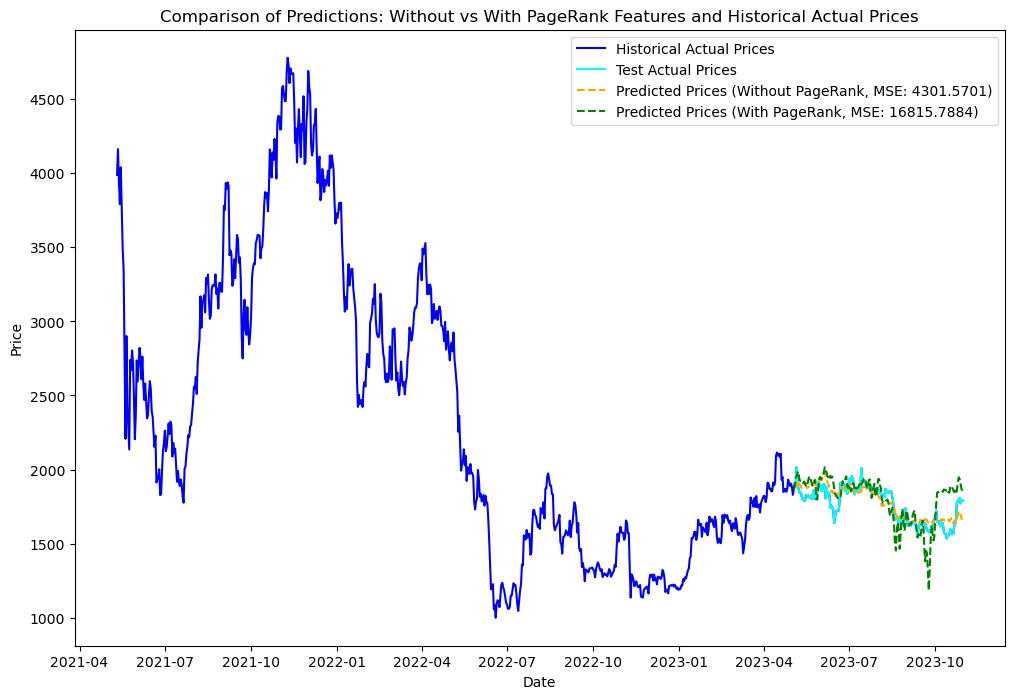

In [3]:
# Plot comparison with historical actual prices
plt.figure(figsize=(12, 8))

# Plot the entire historical actual prices for reference
plt.plot(dates_without, y_without, label='Historical Actual Prices', color='blue', linestyle='-')

# Plot the actual prices for the test period
plt.plot(dates_without.iloc[-len(y_test_original_without):], y_test_original_without, label='Test Actual Prices', color='cyan', linestyle='-')

# Plot the predicted prices without PageRank features
plt.plot(dates_without.iloc[-len(y_pred_adjusted_without):], y_pred_adjusted_without, label=f'Predicted Prices (Without PageRank, MSE: {mse_without:.4f})', linestyle='--', color='orange')

# Plot the predicted prices with PageRank features
plt.plot(dates_with.iloc[-len(y_pred_adjusted_with):], y_pred_adjusted_with, label=f'Predicted Prices (With PageRank, MSE: {mse_with:.4f})', linestyle='--', color='green')

plt.title('Comparison of Predictions: Without vs With PageRank Features and Historical Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Adjust date formatting for better readability
plt.gca().xaxis.set_major_locator
